In [1]:
from Utils.Solver import *
from Utils.Signals import *

In [2]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores
start_date ='2021-01-15'
end_date ='2022-01-15'

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


## Signals 

In [3]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


### RSI SIGNAL

In [4]:
# Calculate the RSI signal scores
rsi_signal_scores = calculate_rsi_signal(data, tickers, date='2022-12-23', period=14)
rsi_scores = [score[1] for score in rsi_signal_scores]
rsi_scores_array = np.array(rsi_scores)
print(rsi_scores_array)

[35.69465321 44.14047175 19.81992342 38.02756082 40.44857309]


     pcost       dcost       gap    pres   dres
 0: -2.0655e-01 -1.7861e+00  2e+00  0e+00  4e-16
 1: -2.0792e-01 -2.8239e-01  7e-02  7e-17  3e-16
 2: -2.2466e-01 -2.3763e-01  1e-02  1e-16  5e-17
 3: -2.2664e-01 -2.2884e-01  2e-03  2e-16  8e-17
 4: -2.2762e-01 -2.2778e-01  2e-04  2e-16  3e-17
 5: -2.2766e-01 -2.2767e-01  2e-06  2e-16  4e-17
 6: -2.2766e-01 -2.2766e-01  2e-08  1e-16  2e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.10000010495716999), 'MSFT': np.float64(0.2999999714671243), 'TSLA': np.float64(8.412150043164188e-09), 'AMZN': np.float64(0.29999996480064384), 'GOOG': np.float64(0.29999995036291177)}
Final Portfolio Weights: [1.00000105e-01 2.99999971e-01 8.41215004e-09 2.99999965e-01
 2.99999950e-01]


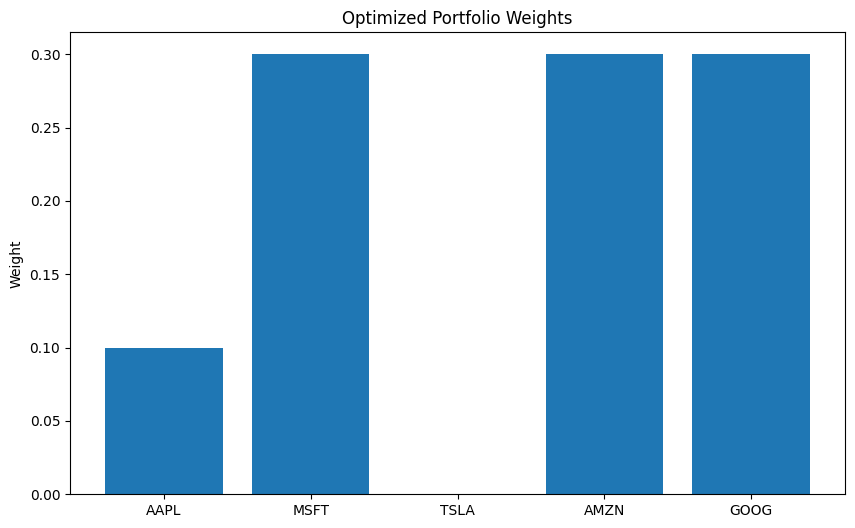

In [5]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
# TODO: Change for all the data in the past 10 years
rsi_portfolio_weights = portfolio_solver.SolveSignalPortfolio2(tickers, data, rsi_scores_array)
print("Final Portfolio Weights:", rsi_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

Total Portfolio Return: 147.66%
Annualized Portfolio Return: 147.66%


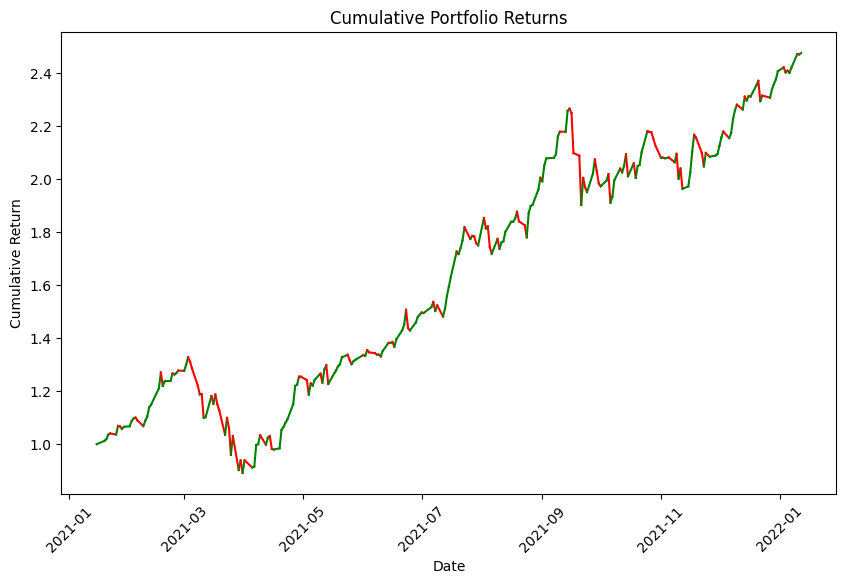

In [6]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, rsi_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### MACD signal

In [7]:
# Calculate MACD for a specific date (e.g., '2021-01-15')
macd_signal = calculate_macd_signal(data, tickers, '2021-01-15')
macd_scores = [score[1] for score in macd_signal]
macd_scores_array = np.array(macd_scores)

     pcost       dcost       gap    pres   dres
 0: -5.1576e+00 -3.2420e+00  2e+01  5e+00  1e+00
 1: -9.9484e-01 -1.9725e+00  1e+00  9e-03  2e-03
 2: -1.0944e+00 -1.1813e+00  9e-02  7e-04  2e-04
 3: -1.1233e+00 -1.1306e+00  7e-03  2e-05  4e-06
 4: -1.1260e+00 -1.1268e+00  8e-04  1e-16  7e-17
 5: -1.1262e+00 -1.1262e+00  7e-05  6e-17  4e-16
 6: -1.1262e+00 -1.1262e+00  9e-07  2e-16  1e-16
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.33481563872694514), 'MSFT': np.float64(0.6384773945705695), 'TSLA': np.float64(3.039939866357471e-09), 'AMZN': np.float64(0.026706948365161333), 'GOOG': np.float64(1.5297384073829004e-08)}
Final Portfolio Weights: [3.34815639e-01 6.38477395e-01 3.03993987e-09 2.67069484e-02
 1.52973841e-08]


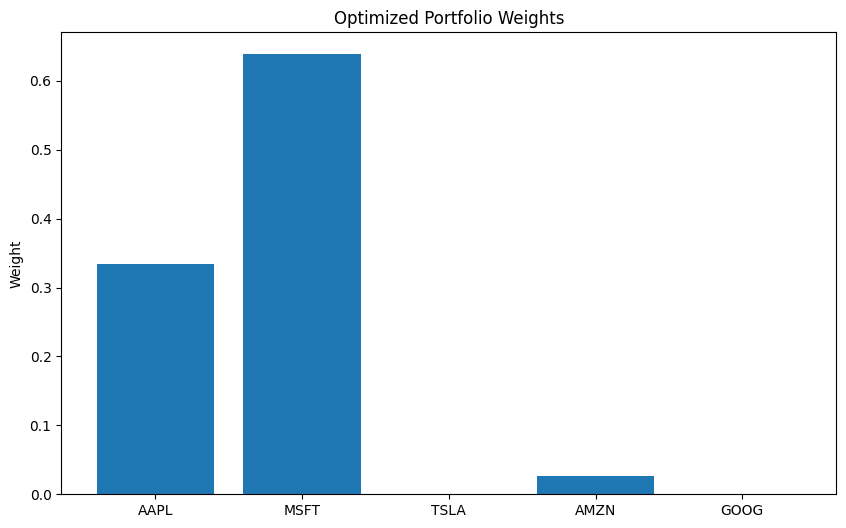

In [8]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
macd_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, macd_scores_array)
print("Final Portfolio Weights:", macd_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=macd_portfolio_weights)

Total Portfolio Return: 76.57%
Annualized Portfolio Return: 76.57%


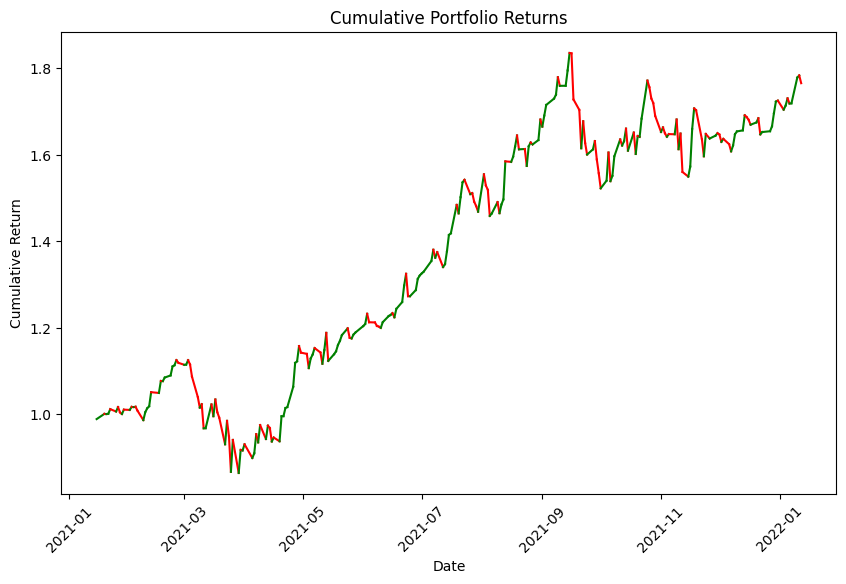

In [9]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, macd_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### SMA signal

In [10]:
# Calculate SMA crossover signal for a specific date (e.g., '2021-01-15')
sma_signal = calculate_sma_signal(data, tickers, '2021-01-15')
sma_scores = [score[1] for score in sma_signal]
sma_scores_array = np.array(sma_scores)
print(sma_scores_array)

[19.99331354 13.46059578 81.52420954 11.69167049 11.39483021]


     pcost       dcost       gap    pres   dres
 0: -2.0345e-01 -1.3608e+00  1e+00  0e+00  3e+00
 1: -2.2219e-01 -3.2681e-01  1e-01  2e-16  3e-01
 2: -2.3998e-01 -2.5115e-01  1e-02  1e-16  8e-17
 3: -2.4069e-01 -2.4133e-01  6e-04  5e-17  4e-17
 4: -2.4070e-01 -2.4071e-01  8e-06  1e-16  3e-17
 5: -2.4070e-01 -2.4070e-01  8e-08  1e-16  8e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.13101377085602273), 'MSFT': np.float64(0.07186850580320299), 'TSLA': np.float64(0.6880979704742965), 'AMZN': np.float64(0.0558535467434676), 'GOOG': np.float64(0.05316620612301017)}
Final Portfolio Weights: [0.13101377 0.07186851 0.68809797 0.05585355 0.05316621]


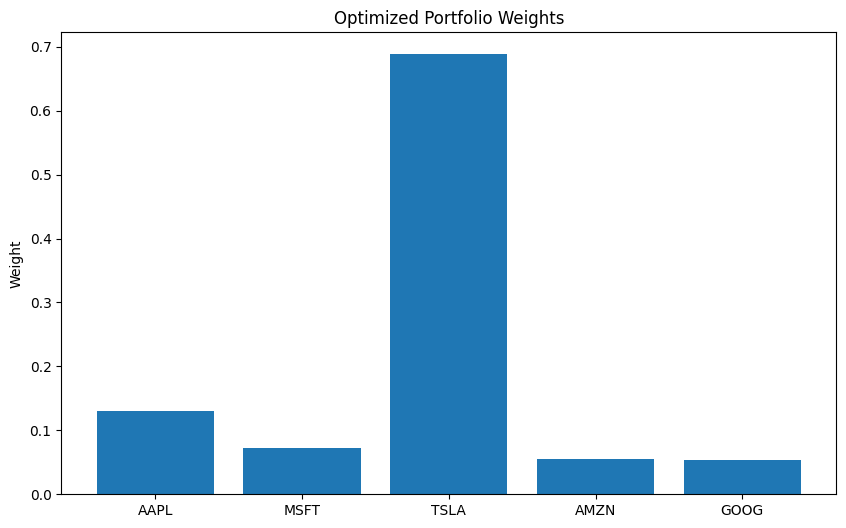

In [11]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
sma_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, sma_scores_array)
print("Final Portfolio Weights:", sma_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=sma_portfolio_weights)

Total Portfolio Return: 54.65%
Annualized Portfolio Return: 54.65%


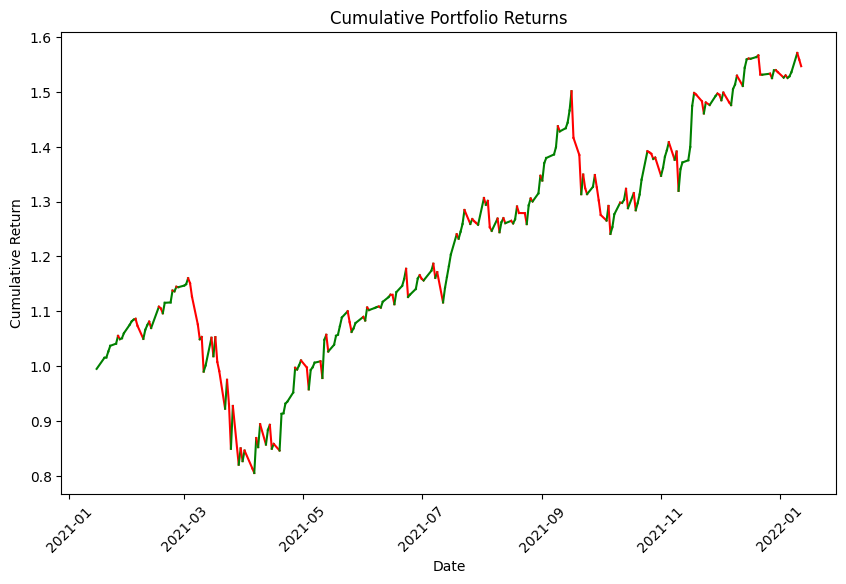

In [12]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

rsi_signal_scores [48.09326421 42.67413468 66.28230185 42.67309414 46.45342527]
macd_signal_scores [-0.81745076 -0.98491478  1.88721933 -0.64751188 -0.12669445]
sma_signal_scores [19.99331354 13.46059578 81.52420954 11.69167049 11.39483021]
[ 67.26912699  55.14981568 149.69373072  53.71725276  57.72156103]
     pcost       dcost       gap    pres   dres
 0: -1.3988e-01 -1.2314e+00  1e+00  0e+00  3e+00
 1: -1.4431e-01 -2.1518e-01  7e-02  4e-17  2e-01
 2: -1.4874e-01 -1.5166e-01  3e-03  6e-17  3e-17
 3: -1.4876e-01 -1.4879e-01  3e-05  7e-17  5e-17
 4: -1.4876e-01 -1.4876e-01  3e-07  7e-17  1e-17
 5: -1.4876e-01 -1.4876e-01  3e-09  3e-17  5e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.1692310814790182), 'MSFT': np.float64(0.12973407222828362), 'TSLA': np.float64(0.4378540898724148), 'AMZN': np.float64(0.12506533006920492), 'GOOG': np.float64(0.13811542635107849)}


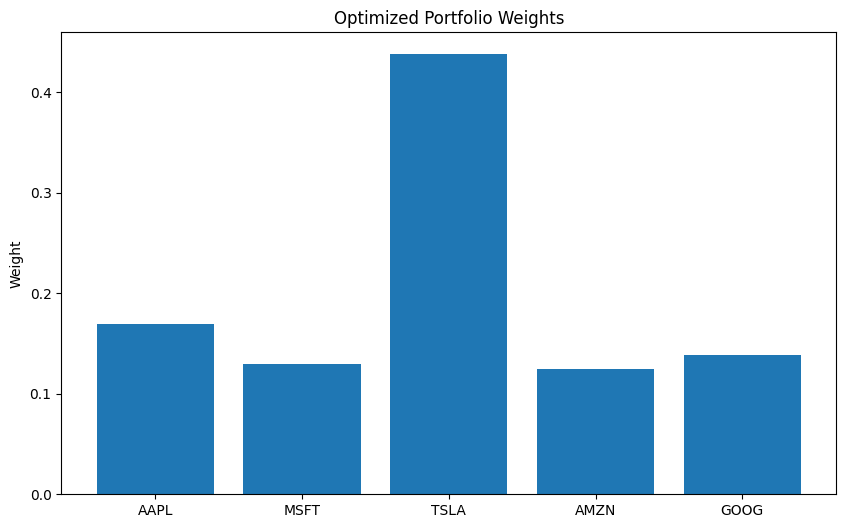

Total Portfolio Return: 92.24%
Annualized Portfolio Return: 92.24%


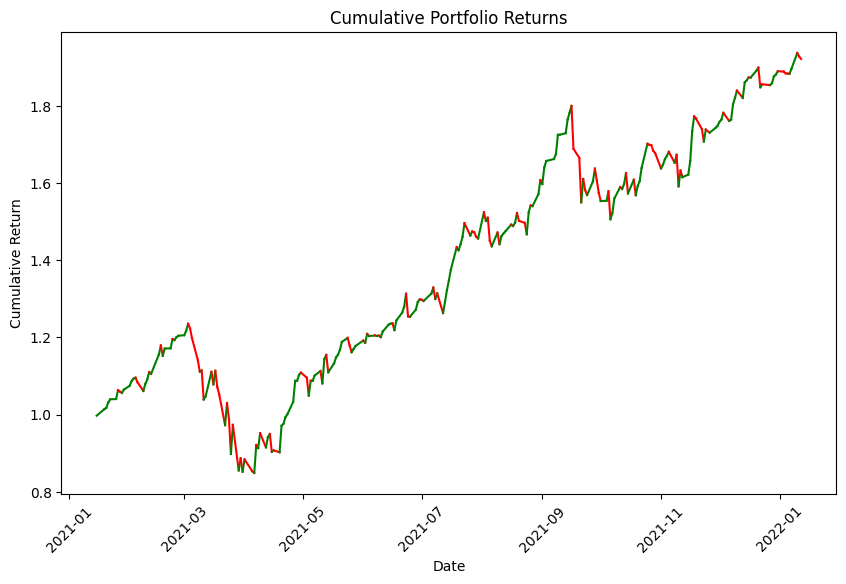

In [13]:

trading_dates = ['2021-01-15']
# Example of Iterative Optimization
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    


# Prepare data

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2020-01-01'
end_date = '2021-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = [1, 1, 1]  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)
    
    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df)

[*********************100%***********************]  5 of 5 completed


processing 2020-01-01 00:00:00
Skipping 2020-01-01 00:00:00 due to NaN values in the signals.
processing 2020-01-02 00:00:00
RSI : [['AAPL', np.float64(84.60774802299971)], ['MSFT', np.float64(76.61384766802396)], ['TSLA', np.float64(75.72662189969572)], ['AMZN', np.float64(72.35671322639156)], ['GOOG', np.float64(63.30785040793726)]]
MACD : [['AAPL', np.float64(0.33128742790926213)], ['MSFT', np.float64(0.14369425469190222)], ['TSLA', np.float64(0.16461625863005458)], ['AMZN', np.float64(0.5749701407741094)], ['GOOG', np.float64(-0.10296499112262236)]]
SMA : [11.47499428 13.13599087  5.6645734  -2.32544498  5.20245739]
Combined Scores [('AAPL', np.float64(96.41402972886308)), ('MSFT', np.float64(89.89353279033061)), ('TSLA', np.float64(81.55581156073055)), ('AMZN', np.float64(70.60623838272964)), ('GOOG', np.float64(68.40734280664617))]
     pcost       dcost       gap    pres   dres
 0: -1.2152e-01 -1.1410e+00  1e+00  0e+00  3e+00
 1: -1.2182e-01 -1.4598e-01  2e-02  5e-17  6e-02
 2: 

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2020-01-02,"[84.60774802299971, 76.61384766802396, 75.7266...","[0.33128742790926213, 0.14369425469190222, 0.1...","[11.47499427795411, 13.135990867614737, 5.6645...","[96.41402972886308, 89.89353279033061, 81.5558...","[0.2462013778990383, 0.2261692283915571, 0.200...",0.221965,4.386328
1,2020-01-03,"[77.73362321903066, 65.79069026354473, 78.6274...","[0.30405000762093737, 0.049235893564657296, 0....","[11.622064228057866, 13.367627792358405, 5.858...","[89.65973745470947, 79.2075539494678, 84.66490...","[0.24316306229249166, 0.20898725603521878, 0.2...",0.227134,4.580761
2,2020-01-06,"[79.21005971144487, 66.82536792985653, 80.3217...","[0.2906757327811367, -0.010597229388531026, 0....","[11.770496311187749, 13.601335449218737, 6.061...","[91.27123175541377, 80.41610614968673, 86.5845...","[0.23504298585402175, 0.2011420908824343, 0.22...",0.237230,4.978386
3,2020-01-07,"[75.98199017586695, 59.92287619777302, 83.2575...","[0.2276267299965391, -0.15887629174587303, 0.2...","[11.907037982940679, 13.747935333251945, 6.218...","[88.11665488880418, 73.5119352392791, 89.74124...","[0.22978972261236338, 0.18341656637599363, 0.2...",0.256517,5.807905
4,2020-01-08,"[79.10397117870092, 66.39375772051919, 86.1821...","[0.23217692638131293, -0.1132237718757012, 0.3...","[12.043761596679694, 13.918323822021506, 6.360...","[91.37990970176193, 80.198857770665, 92.916011...","[0.23207020310360413, 0.19755670225459365, 0.2...",0.223225,4.433179
...,...,...,...,...,...,...,...,...
248,2020-12-24,"[67.92105587375214, 61.41409087026373, 62.8719...","[0.6376328219374119, 0.8196507356296214, -1.10...","[20.276958198547362, 16.262741622924807, 64.36...","[88.83564689423692, 78.49648322881816, 126.137...","[0.21600798014782208, 0.18504856146521614, 0.3...",0.134799,1.892805
249,2020-12-28,"[73.64751097673572, 64.36479056203076, 63.1416...","[0.877413523378308, 0.8857978960486315, -1.163...","[20.262905502319327, 16.051132125854508, 64.87...","[94.78783000243335, 81.3017205839339, 126.8528...","[0.21480982524930828, 0.17713353081845656, 0.3...",0.104820,1.310192
250,2020-12-29,"[68.56503068746103, 62.478902460361454, 63.483...","[0.8423524603289363, 0.8160753102317488, -1.22...","[20.211754055023206, 15.715763702392564, 65.42...","[89.61913720281318, 79.01074147298576, 127.679...","[0.20481389716805956, 0.17465106968313734, 0.3...",0.101063,1.245034
251,2020-12-30,"[65.48947970813343, 56.99509309342774, 67.5459...","[0.676704537987141, 0.5607947754375087, -0.718...","[20.215961551666254, 15.502699661254866, 66.16...","[86.38214579778682, 73.05858753012012, 132.993...","[0.2032328128861722, 0.16417425556655055, 0.33...",0.109215,1.388544


Calculate all the return for each of those dates



In [37]:
average_annualized_return = df['annualized_return'].mean()
print("Average return for 1/N : ", average_annualized_return)

total_return_sum = df['total_return'].sum()
print(f"Total Return Sum: {total_return_sum}")

Average return for 1/N :  1.8176886464183812
Total Return Sum: 23.114879072293697


### Matrix of size signals 

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2010-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2011-01-01'
end_date = '2021-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    #print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        #print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    # Calculate the average scores for each signal type (RSI, MACD, SMA)
    avg_rsi = np.mean(rsi_scores)
    avg_macd = np.mean(macd_scores)
    avg_sma = np.mean(sma_scores)

    # Add the aggregated values to the dataset
    dataset.append({
        'date': date,
        'rsi_avg': avg_rsi,
        'macd_avg': avg_macd,
        'sma_avg': avg_sma,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'total_return': total_return 
    })

# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Prepare the feature matrix X (aggregated values for RSI, MACD, SMA)
X = df[['rsi_avg', 'macd_avg', 'sma_avg']].values

# Prepare the target y (total return)
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W (size should be 3)
W, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):")
print(W)


[*********************100%***********************]  5 of 5 completed


Learned Weight Matrix (W):
[[ 2.01654167e-03]
 [-2.59775649e-02]
 [-4.56540720e-05]]


In [41]:
# Define the target date range
start_date = '2020-01-01'
end_date = '2021-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset2 = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)
    
    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset2.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df2 = pd.DataFrame(dataset2)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df2)

processing 2020-01-01 00:00:00
Skipping 2020-01-01 00:00:00 due to NaN values in the signals.
processing 2020-01-02 00:00:00
RSI : [['AAPL', np.float64(84.60790339128073)], ['MSFT', np.float64(76.61374739815481)], ['TSLA', np.float64(75.72662189969572)], ['AMZN', np.float64(72.35671322639156)], ['GOOG', np.float64(63.30780003793603)]]
MACD : [['AAPL', np.float64(0.33128699041863374)], ['MSFT', np.float64(0.14369481927322436)], ['TSLA', np.float64(0.16461625863005458)], ['AMZN', np.float64(0.5749701407741094)], ['GOOG', np.float64(-0.10296521542415027)]]
SMA : [11.47499418 13.13598675  5.6645734  -2.32544498  5.20245657]
Combined Scores [('AAPL', np.float64(0.1614854530595766)), ('MSFT', np.float64(0.15016226113635267)), ('TSLA', np.float64(0.14817094799821107)), ('AMZN', np.float64(0.13108016900056016)), ('GOOG', np.float64(0.13010008888623248))]
     pcost       dcost       gap    pres   dres
 0: -1.2060e-01 -1.1335e+00  1e+00  0e+00  3e+00
 1: -1.2072e-01 -1.4018e-01  2e-02  7e-17  5

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2020-01-02,"[84.60790339128073, 76.61374739815481, 75.7266...","[0.33128699041863374, 0.14369481927322436, 0.1...","[11.47499418258667, 13.135986747741697, 5.6645...","[0.1614854530595766, 0.15016226113635267, 0.14...","[0.22996823893629154, 0.21033716201549632, 0.2...",0.232846,4.802736
1,2020-01-03,"[77.7335404167517, 65.79054858748636, 78.62741...","[0.30404857976117294, 0.049234761615698286, 0....","[11.622064151763915, 13.367623558044443, 5.858...","[0.14832388692352114, 0.1307800968782444, 0.15...","[0.2253020292633117, 0.19273924904014728, 0.23...",0.237001,4.969091
2,2020-01-06,"[79.21001965808844, 66.82534502575753, 80.3217...","[0.2906747303714843, -0.010596430409539614, 0....","[11.770495986938478, 13.601330795288078, 6.061...","[0.15164191235782712, 0.13441040600186882, 0.1...","[0.21871864328937055, 0.18818339502622183, 0.2...",0.246548,5.367301
3,2020-01-07,"[75.98195596072416, 59.92282647523087, 83.2575...","[0.22762604664669017, -0.15887528638294635, 0....","[11.907037487030024, 13.747931556701644, 6.218...","[0.146764005007012, 0.12433642042225286, 0.160...","[0.2145420471170423, 0.1741163996252574, 0.239...",0.263762,6.144766
4,2020-01-08,"[79.10393787206036, 66.39378282113158, 86.1821...","[0.2321764802397519, -0.11321975902893255, 0.3...","[12.043761272430423, 13.918321495056148, 6.360...","[0.15293516043422423, 0.13619157510050686, 0.1...","[0.21876453630297588, 0.18933979108651697, 0.2...",0.228558,4.635380
...,...,...,...,...,...,...,...,...
248,2020-12-24,"[67.92101405180844, 61.41411018578539, 62.8719...","[0.6376318481448022, 0.8196523865641094, -1.10...","[20.276957721710204, 16.262741775512694, 64.36...","[0.11947570649835036, 0.10180907867568495, 0.1...","[0.20771039656847384, 0.1696032895335476, 0.27...",0.143910,2.093795
249,2020-12-28,"[73.6475069778253, 64.36475754631333, 63.14165...","[0.877413618123497, 0.8857996081005193, -1.163...","[20.262905330657958, 16.051132202148438, 64.87...","[0.12479511314157476, 0.10605049912010382, 0.1...","[0.20138652504367238, 0.16362760175866164, 0.2...",0.114828,1.491983
250,2020-12-29,"[68.56491135849238, 62.4788757582182, 63.48388...","[0.8423502879718279, 0.8160769870257636, -1.22...","[20.211753845214844, 15.715763702392564, 65.42...","[0.11545904250624578, 0.10407407476844528, 0.1...","[0.1904346876513299, 0.16672644534043365, 0.27...",0.106265,1.335698
251,2020-12-30,"[65.48945436173082, 56.99495477520794, 67.5459...","[0.6767030005109764, 0.5607924594729272, -0.71...","[20.215961170196536, 15.502699279785162, 66.16...","[0.11356017641016207, 0.09965691725446667, 0.1...","[0.19891875992484007, 0.16844344700140587, 0.2...",0.107482,1.357376


In [42]:
average_annualized_return = df2['annualized_return'].mean()
print("Average return for trained matrix : ", average_annualized_return)

total_return_sum = df2['total_return'].sum()
print(f"Total Return Sum: {total_return_sum}")

Average return for trained matrix :  2.1439009806367544
Total Return Sum: 26.447374540646926


### Matrix of size tickers x signals 

In [21]:
# Create the feature matrix dynamically
X = np.array([[
    row['rsi_scores'][i],  # Get RSI score for the i-th ticker
    row['macd_scores'][i],  # Get MACD score for the i-th ticker
    row['sma_scores'][i]    # Get SMA score for the i-th ticker
] for _, row in df.iterrows() for i in range(len(tickers))]).reshape(len(df), len(tickers) * 3)

# Ensure the shape of X is correct (it should be 2D with each row representing a data point)
#print("Shape of X:", X.shape)
#print(X)

# Target (returns), you can choose 'total_return' or 'annualized_return' based on your preference
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W
# Using np.linalg.lstsq to solve the least squares problem, i.e., Y = XW
W2, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):", W2)


Learned Weight Matrix (W): [[ 0.00013018]
 [-0.00116426]
 [ 0.00130203]
 [-0.00068253]
 [ 0.00111505]
 [-0.0005918 ]
 [-0.00039366]
 [ 0.00243673]
 [-0.00022293]
 [-0.00027519]
 [ 0.00692536]
 [-0.00013682]
 [-0.00019956]
 [ 0.00737587]
 [-0.00064585]]


[[ 0.00013018 -0.00116426  0.00130203]
 [-0.00068253  0.00111505 -0.0005918 ]
 [-0.00039366  0.00243673 -0.00022293]
 [-0.00027519  0.00692536 -0.00013682]
 [-0.00019956  0.00737587 -0.00064585]]
[[ 4.46889153e-03  9.39861437e-05 -1.25771534e-03 ... -9.35518716e-03
  -4.98330506e-04 -3.81507058e-03]
 [ 3.88729843e-03  1.24607797e-04 -1.29839799e-03 ... -9.42416590e-03
  -8.20565544e-04 -3.84390139e-03]
 [ 3.51249051e-03  1.65278194e-04 -1.36705873e-03 ... -9.52687685e-03
  -9.77083721e-04 -3.84070988e-03]
 ...
 [ 8.92549971e-03 -9.80717924e-04  2.63163842e-02 ... -1.03010455e-02
  -2.23638238e-03 -7.35543498e-03]
 [ 8.52513776e-03 -7.87860546e-04  2.63218625e-02 ... -9.44882966e-03
  -2.23123462e-03 -7.38756255e-03]
 [ 8.17160333e-03 -5.16736180e-04  2.62590620e-02 ... -1.00187639e-02
  -1.84640902e-03 -7.40824816e-03]]


TODO: Apply W to all and calculate the return on every date

# RENDU ICI 

In [ ]:
# Let's test the model with some input signals (for example, RSI=0.4, MACD=0.5, SMA=1.8)
test_data = np.array([[0.4, 0.5, 1.8]])

# Ensure test_data has the same shape as the learned weight matrix
print("Shape of test_data:", test_data.shape)

weighted_values = test_data[0] * W.flatten()
print("Weighted values : ", weighted_values)
# Predicted return (make sure the shapes are aligned)

#TODO: Solve Portfolio
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, weighted_values)
print("Final Portfolio Weights:", portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

#TODO: Display



print("Predicted Return for input [RSI=0.4, MACD=0.5, SMA=1.8]:", )

Shape of test_data: (1, 3)
Weighted values :  [-0.00058665  0.00811233 -0.00014853]


TypeError: 'P' must be a 'd' matrix of size (3, 3)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2022-01-01'
end_date = '2022-05-05'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
res_dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)

    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])


    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    res_dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
res_data = pd.DataFrame(res_dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)


# You can now use this DataFrame for training your model.
display(res_data)